In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import lightgbm as lgbm
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
smpl_sub = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,white
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,red
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,white
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,white


## 구분자 / 품질 / 산도 / 휘발성산 / 시트르산 / 잔당 / 염화물 / 독립 이산화황 / 총 이산화황 / 밀도 / 수소이온농도 / 황산염 / 도수 / 종류

In [5]:
test.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,9.0,0.31,0.48,6.6,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,white
1,1,13.3,0.43,0.58,1.9,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,red
2,2,6.5,0.28,0.27,5.2,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,white
3,3,7.2,0.15,0.39,1.8,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,white
4,4,6.8,0.26,0.26,2.0,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,white


### 종류에 있는 white / red 각각 0, 1로 구분

In [6]:
train['type'] = train['type'].map({'white' : 0, 'red' : 1}).astype(int)
test['type'] = test['type'].map({'white' : 0, 'red' : 1}).astype(int)

In [7]:
train.head()

,index,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,0,5,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,1,5,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,2,5,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,3,6,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,4,6,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0


<AxesSubplot:>

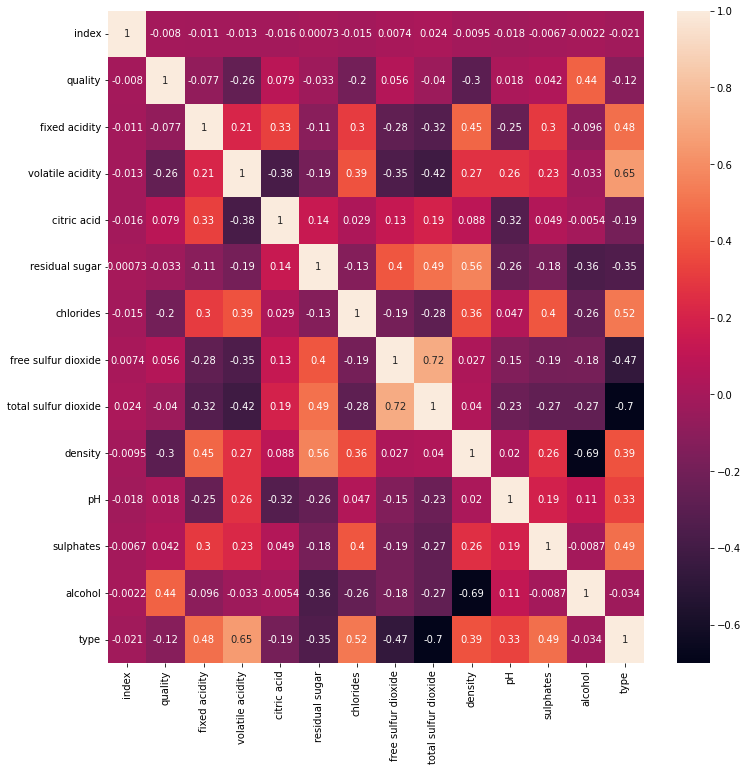

In [8]:
plt.figure(figsize=(12,12))
sns.heatmap(data = train.corr(), annot=True)

## 데이터 정형화

### index, quality X에서는 삭제 y에 퀄리티 추가

In [9]:
train_X = train.drop(['index', 'quality'], axis = 1)
train_y = train['quality']
test_X = test.drop('index', axis = 1)

In [10]:
train_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,5.6,0.695,0.06,6.8,0.042,9.0,84.0,0.99432,3.44,0.44,10.2,0
1,8.8,0.610,0.14,2.4,0.067,10.0,42.0,0.99690,3.19,0.59,9.5,1
2,7.9,0.210,0.39,2.0,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,0
3,7.0,0.210,0.31,6.0,0.046,29.0,108.0,0.99390,3.26,0.50,10.8,0
4,7.8,0.400,0.26,9.5,0.059,32.0,178.0,0.99550,3.04,0.43,10.9,0


In [11]:
test_X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,9.0,0.31,0.48,6.60,0.043,11.0,73.0,0.99380,2.90,0.38,11.6,0
1,13.3,0.43,0.58,1.90,0.070,15.0,40.0,1.00040,3.06,0.49,9.0,1
2,6.5,0.28,0.27,5.20,0.040,44.0,179.0,0.99480,3.19,0.69,9.4,0
3,7.2,0.15,0.39,1.80,0.043,21.0,159.0,0.99480,3.52,0.47,10.0,0
4,6.8,0.26,0.26,2.00,0.019,23.5,72.0,0.99041,3.16,0.47,11.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.1,0.59,0.02,2.30,0.082,24.0,94.0,0.99744,3.55,0.53,9.7,1
996,8.7,0.15,0.30,1.60,0.046,29.0,130.0,0.99420,3.22,0.38,9.8,0
997,8.8,0.66,0.26,1.70,0.074,4.0,23.0,0.99710,3.15,0.74,9.2,1
998,7.0,0.42,0.19,2.30,0.071,18.0,36.0,0.99476,3.39,0.56,10.9,1


In [12]:
train_X.shape

(5497, 12)

In [13]:
train_y.shape

(5497,)

In [14]:
test_X.shape

(1000, 12)

## 모델 생성

In [15]:
# model = lgbm.LGBMClassifier(n_estimators=400)
# model.fit(train_X, train_y)

In [16]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
model = XGBClassifier()

In [17]:
x_param_grid = {
    'n_estimaters' : [100, 200, 300, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12, 14],
}


In [18]:

model = GridSearchCV(model, param_grid = x_param_grid, scoring= 'accuracy', n_jobs = -1, verbose = 1)
model.fit(train_X, train_y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [4, 6, 8, 10, 12, 14],
                         'n_estimaters': [100, 200, 300, 400, 600]},
             scoring='accuracy', verbose=1)

In [19]:
print('최고 평균 정확도 : {0:.4f}'.format(model.best_score_))
print('최고의 파라미터 : ', model.best_params_)

최고 평균 정확도 : 0.6638
최고의 파라미터 :  {'learning_rate': 0.05, 'max_depth': 14, 'n_estimaters': 100}


In [22]:
model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth = 14)
model.fit(train_X, train_y)

XGBClassifier(learning_rate=0.05, max_depth=14, objective='multi:softprob')

In [23]:
y_pred = model.predict(test_X)

In [24]:
y_pred

array([5, 5, 6, 5, 6, 6, 6, 6, 6, 7, 6, 6, 7, 6, 6, 5, 6, 6, 6, 6, 6, 6,
       5, 7, 6, 5, 5, 5, 5, 5, 7, 6, 5, 6, 5, 6, 5, 5, 6, 6, 6, 5, 5, 5,
       6, 7, 5, 7, 4, 6, 5, 5, 6, 4, 5, 6, 6, 5, 5, 6, 5, 6, 6, 4, 6, 6,
       5, 5, 6, 5, 5, 5, 5, 6, 6, 5, 6, 7, 6, 7, 6, 6, 5, 5, 6, 6, 5, 5,
       6, 7, 6, 6, 6, 6, 6, 7, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 7, 5,
       7, 6, 6, 5, 5, 6, 6, 7, 7, 6, 6, 5, 6, 6, 5, 5, 6, 6, 6, 7, 5, 5,
       6, 5, 5, 6, 6, 7, 5, 5, 5, 6, 5, 5, 5, 5, 7, 6, 8, 6, 5, 8, 6, 5,
       6, 5, 5, 5, 6, 5, 5, 6, 6, 6, 6, 5, 6, 6, 5, 6, 5, 5, 6, 5, 6, 6,
       6, 5, 6, 6, 6, 6, 7, 7, 5, 6, 6, 6, 5, 6, 6, 5, 5, 6, 6, 6, 7, 5,
       5, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 7, 5, 5, 6, 6, 6, 5, 6, 6, 7,
       6, 5, 6, 6, 7, 6, 6, 5, 6, 5, 6, 7, 7, 6, 6, 6, 5, 6, 6, 7, 6, 6,
       6, 6, 7, 6, 6, 6, 5, 6, 5, 6, 7, 7, 6, 6, 6, 7, 7, 6, 7, 6, 5, 7,
       5, 5, 6, 5, 6, 6, 6, 5, 5, 5, 6, 5, 7, 7, 5, 6, 6, 6, 6, 5, 7, 7,
       6, 6, 6, 6, 5, 5, 5, 6, 5, 7, 8, 5, 5, 7, 7,

In [25]:
smpl_sub

,index,quality
0,0,5
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
995,995,6
996,996,5
997,997,5
998,998,6


In [26]:
smpl_sub['quality'] = y_pred

In [27]:
smpl_sub

,index,quality
0,0,5
1,1,5
2,2,6
3,3,5
4,4,6
...,...,...
995,995,6
996,996,6
997,997,5
998,998,6


In [28]:
smpl_sub.to_csv('submission3.csv', index=False)